# RecSys
Modelo do tipo recuperação

## Importando bibliotecas necessárias

In [2]:
from torch.utils.data import DataLoader
from torcheval.metrics import R2Score
from torch.utils.tensorboard import SummaryWriter
from dataset import MovieLens
from models import  MovieLensRecSys

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

Carregando Tensor Board

In [3]:
writer = SummaryWriter('runs/movie-lens')
writer.flush()

Configurando dispositivo para utilizar GPU se possível; caso contrário, CPU

In [4]:
mode = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(mode)
device

device(type='cuda')

In [5]:
torch.set_default_device(device)

In [6]:
generator = torch.Generator(device)

## Carregando dados do Movie Lens

In [7]:
df_movie_lens = MovieLens('./data/movie-lens/raw/ratings.csv', device)

In [8]:
pd.Series(df_movie_lens.ratings).value_counts(normalize=True)

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: proportion, dtype: float64

## Carregando dados

Dividindo dataset entre conjunto de treinamento, validação e teste

In [9]:
dataset_length = len(df_movie_lens)

train_length = int(dataset_length * 0.7)
valid_length = int(dataset_length * 0.15)
test_length  = dataset_length - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset=df_movie_lens,
    lengths=(train_length, valid_length, test_length),
    generator=generator
)

Ajustando dataset para ser utilizado pelo PyTorch como um iterável que retorna lotes de dados a cada iteração

In [10]:
BATCH_SIZE = 8

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
validation_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Após isso, toda vez que o DataLoader for requisitado, ele retornará um lote (batch) de 8 itens

In [12]:
dataiter = iter(train_loader)
batch = next(dataiter)
batch

{'users': tensor([131, 331, 599, 379, 142, 177, 386, 413], device='cuda:0'),
 'movies': tensor([ 698,  686, 1004, 2038, 1290,  395, 5122, 6959], device='cuda:0'),
 'ratings': tensor([3, 4, 2, 3, 4, 4, 4, 3], device='cuda:0')}

## Criando modelo de RecSys

Criando modelo de RecSys no estilo de torre-dupla

Contando quantidade de clientes e produtos distintos envolvidos em compras

In [13]:
n_users = df_movie_lens.n_unique_users
n_movies = df_movie_lens.n_unique_movies
n_users, n_movies

(610, 9724)

Instanciando modelo RecSys, configurando otimizador, taxa de aprendizado e função custo

In [14]:
model = MovieLensRecSys(n_users, n_movies).to(device)
model

MovieLensRecSys(
  (users_embedding): Embedding(610, 128)
  (movies_embedding): Embedding(9724, 128)
  (fully_conn_1): Linear(in_features=256, out_features=128, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (fully_conn_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.2, inplace=False)
  (fully_conn_3): Linear(in_features=64, out_features=32, bias=True)
  (relu_3): ReLU()
  (dropout_3): Dropout(p=0.2, inplace=False)
  (fully_conn_4): Linear(in_features=32, out_features=16, bias=True)
  (relu_4): ReLU()
  (dropout_4): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
model.eval()
prev = model(batch)
prev

tensor([[0.1498],
        [0.1532],
        [0.1448],
        [0.1527],
        [0.1477],
        [0.1351],
        [0.1285],
        [0.1518]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
writer.add_graph(model, batch)
writer.flush()

In [17]:
step_size = 4
optimizer = torch.optim.Adam(model.parameters())
scheaduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.7)
loss_function = nn.MSELoss()

Criando o ciclo de treinamento

In [18]:
EPOCHS = 5

In [19]:
list_avg_training_loss = []
list_avg_validation_loss = []
list_global_step = []

model.train()
training_loss = 0.0

for epoch in range(EPOCHS):
    
    training_loss = 0.0

    for i, train_batch in enumerate(train_loader):
        # predições do modelo (y-predito)
        predictions = model(train_batch)
        # calculando tamanho do lote retornado
        batch_length = len(train_batch['ratings'])
        # reformatando y-verdeiro para fical igual ao formato da saída do modelo (y-predito)
        ratings = train_batch['ratings'].view(batch_length, -1).to(torch.float32)
        # calculando o erro do modelo
        loss = loss_function(predictions, ratings)
        # somano erro durante o treinamento
        training_loss += loss.sum().item()
        # executando ajuste dos pesos no modelo via algoritmo de retropropagação
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 999: # a cada 1000 interações de mini-lotes

            validation_loss = 0.0

            model.eval()

            for j, validation_batch in enumerate(validation_loader):

                validation_predictions = model(validation_batch)
                # calculando tamanho do lote retornado
                validation_batch_length = len(validation_batch['ratings'])
                # reformatando y-verdeiro para fical igual ao formato da saída do modelo (y-predito)
                validation_ratings = validation_batch['ratings'].view(validation_batch_length, -1).to(torch.float32)
                # calculando o erro do modelo
                val_loss = loss_function(validation_predictions, validation_ratings)
                # somando erro de validaçao
                validation_loss += val_loss.sum().item()

            model.train()

            avg_training_loss = training_loss / (batch_length * 1000)
            avg_validation_loss = validation_loss / len(validation_loader)
            global_step = epoch * len(train_loader) + i + 1

            print('epoch: %d - batch: %5d - trainig loss: %.5f - validation loss: %.5f' % (epoch + 1, i + 1, avg_training_loss, avg_validation_loss))

            writer.add_scalars(
                main_tag='Training vs Validation Loss',
                tag_scalar_dict={
                    'Training': avg_training_loss,
                    'Validation': avg_validation_loss
                },
                global_step=epoch * len(train_loader) + i
            )

            list_avg_training_loss.append(avg_training_loss)
            list_avg_validation_loss.append(avg_validation_loss)
            list_global_step.append(global_step)

            training_loss = 0.0

df_train_val_loss = pd.DataFrame(
    data={
        'training_loss': list_avg_training_loss,
        'validation_loss': list_avg_validation_loss,
        'global_step': list_global_step
    }
)

epoch: 1 - batch:  1000 - trainig loss: 0.25701 - validation loss: 1.14569
epoch: 1 - batch:  2000 - trainig loss: 0.18887 - validation loss: 1.10919
epoch: 1 - batch:  3000 - trainig loss: 0.16590 - validation loss: 1.05487
epoch: 1 - batch:  4000 - trainig loss: 0.15866 - validation loss: 0.97613
epoch: 1 - batch:  5000 - trainig loss: 0.14916 - validation loss: 0.97787
epoch: 1 - batch:  6000 - trainig loss: 0.14615 - validation loss: 1.00790
epoch: 1 - batch:  7000 - trainig loss: 0.14091 - validation loss: 1.02773
epoch: 1 - batch:  8000 - trainig loss: 0.13504 - validation loss: 0.93173
epoch: 2 - batch:  1000 - trainig loss: 0.12667 - validation loss: 0.91179
epoch: 2 - batch:  2000 - trainig loss: 0.12200 - validation loss: 0.90949
epoch: 2 - batch:  3000 - trainig loss: 0.11716 - validation loss: 0.89946
epoch: 2 - batch:  4000 - trainig loss: 0.12170 - validation loss: 0.90275
epoch: 2 - batch:  5000 - trainig loss: 0.11605 - validation loss: 0.88804
epoch: 2 - batch:  6000 -

In [20]:
df_train_val_loss

,training_loss,validation_loss,global_step
0,0.257014,1.145691,1000
1,0.188868,1.109188,2000
2,0.165904,1.054871,3000
3,0.158662,0.976132,4000
4,0.149159,0.977866,5000
5,0.146152,1.007903,6000
6,0.140911,1.027729,7000
7,0.135037,0.931729,8000
8,0.126665,0.911786,9824
9,0.122004,0.909494,10824


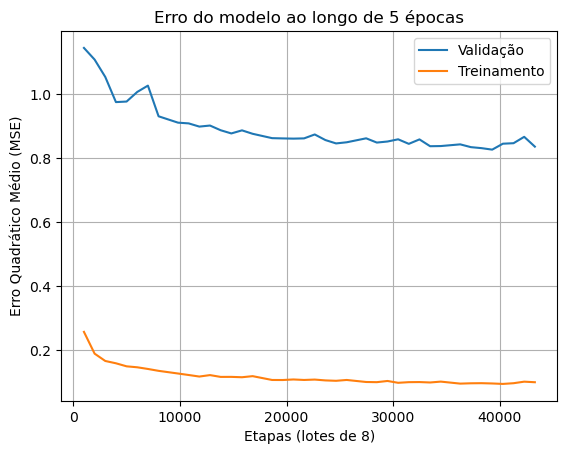

In [29]:
sns.lineplot(
    data=df_train_val_loss,
    x='global_step',
    y='validation_loss',
    label='Validação'
)

sns.lineplot(
    data=df_train_val_loss,
    x='global_step',
    y='training_loss',
    label='Treinamento'
)

plt.grid()
plt.legend()
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Etapas (lotes de 8)')
plt.title(f'Erro do modelo ao longo de {EPOCHS} épocas')
plt.savefig('./images/train_val_loss.png')
plt.show()

In [22]:
torch.save(model, './model/MovieLensRecSys.pt')

## O modelo está sofrendo com super ou sobre ajuste?

In [23]:
model = torch.load('./model/MovieLensRecSys.pt', weights_only=False).to(device)
model.eval()

MovieLensRecSys(
  (users_embedding): Embedding(610, 128)
  (movies_embedding): Embedding(9724, 128)
  (fully_conn_1): Linear(in_features=256, out_features=128, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (fully_conn_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.2, inplace=False)
  (fully_conn_3): Linear(in_features=64, out_features=32, bias=True)
  (relu_3): ReLU()
  (dropout_3): Dropout(p=0.2, inplace=False)
  (fully_conn_4): Linear(in_features=32, out_features=16, bias=True)
  (relu_4): ReLU()
  (dropout_4): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [24]:
full_train_dataset = train_dataset[::]
full_valid_dataset = valid_dataset[::]

pred_train = model(full_train_dataset).squeeze(1)
pred_valid = model(full_valid_dataset).squeeze(1)

true_train = full_train_dataset['ratings']
true_valid = full_valid_dataset['ratings']

In [25]:
r2_score = R2Score()
r2_score.to(device)

In [30]:
r2_score.update(pred_train, true_train)
r2_train = r2_score.compute().item()

r2_score.update(pred_valid, true_valid)
r2_valid = r2_score.compute().item()

r2_train, r2_valid

(0.3951399326324463, 0.38554197549819946)

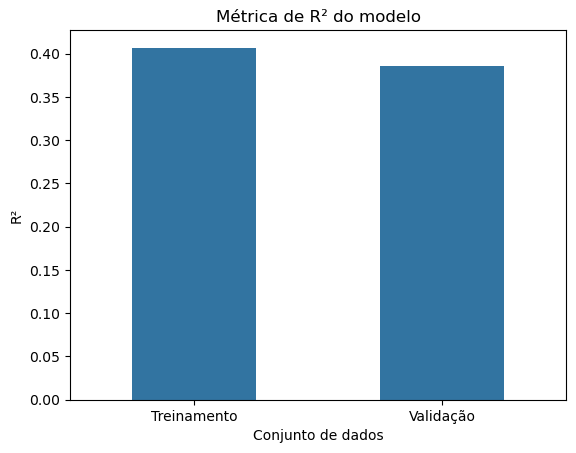

In [27]:
sns.barplot(
    x=['Treinamento', 'Validação'],
    y=[r2_train, r2_valid],
    width=0.5
)

plt.ylabel('R²')
plt.xlabel('Conjunto de dados')
plt.title('Métrica de R² do modelo')
plt.savefig('./images/r2_train_val.png')
plt.show()

Assim vemos que o modelo apresentou um viés (bias) alto, devido a obtenção de um R² baixo, porém com baixa variância. Neste contexto, é recomendado aumentar a complexidade do modelo devido a presenção de sobre ajuste aos dados

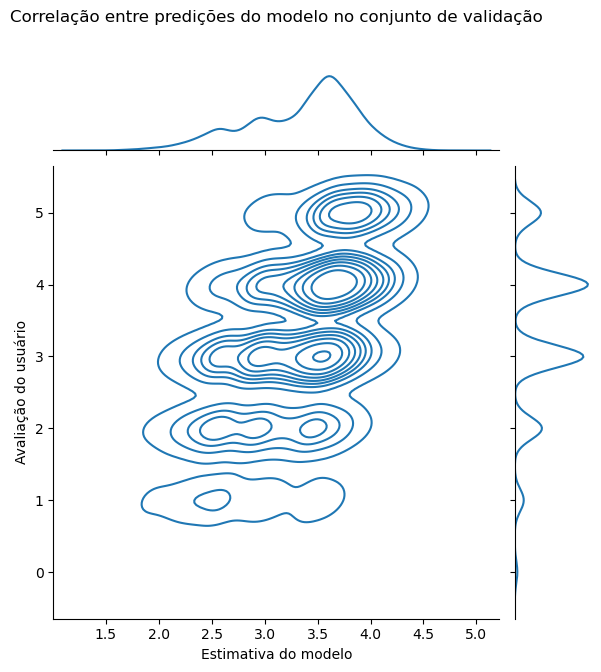

In [31]:
sns.jointplot(
    x=pred_valid.cpu().detach().numpy(),
    y=true_valid.cpu().numpy(),
    kind="kde"
)

plt.ylabel('Avaliação do usuário')
plt.xlabel('Estimativa do modelo')
plt.title('Correlação entre predições do modelo no conjunto de validação', y=1.3)
plt.savefig('./images/corr_val_pred_true.png')
plt.show()

## Avaliando o modelo

In [69]:
model = torch.load('./model/MovieLensRecSys.pt', weights_only=False).to(device)
model.eval()

MovieLensRecSys(
  (users_embedding): Embedding(610, 32)
  (movies_embedding): Embedding(9724, 32)
  (fully_conn_1): Linear(in_features=64, out_features=32, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (fully_conn_2): Linear(in_features=32, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

Calculando o erro quadrádico médio

In [70]:
full_test_dataset = test_dataset[::]

In [71]:
test_true = full_test_dataset['ratings']

with torch.no_grad():
    test_pred = model(full_test_dataset).squeeze(1)

(test_pred - test_true).pow(2).mean()

tensor(0.9037, device='cuda:0')

Mensurando a desempenho do modelo ao avaliar 15 mil dados

In [82]:
%%timeit
model(full_test_dataset)

743 μs ± 26.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


precisão e recall dos K-produtos (Precision@K and Recall@K)

In [73]:
from collections import defaultdict

users_pred_true = defaultdict(list)

with torch.no_grad():

    for i, test_data in enumerate(test_loader):

        users = test_data['users']
        movies = test_data['movies']
        ratings = test_data['ratings']

        output = model(test_data)

        for j in range(len(users)):

            user_id = users[j].item()
            book_id = movies[j].item()

            pred_ratings = output[j][0].item()
            true_ratings = ratings[j].item()

            users_pred_true[user_id].append((pred_ratings, true_ratings))

            print(f'customer_id: {user_id}; product_id: {book_id}; true_ratings: {true_ratings}; pred_ratings: {pred_ratings}')

customer_id: 437; product_id: 40; true_ratings: 3; pred_ratings: 2.471012830734253
customer_id: 379; product_id: 1446; true_ratings: 4; pred_ratings: 3.548279285430908
customer_id: 297; product_id: 2968; true_ratings: 3; pred_ratings: 2.2244319915771484
customer_id: 605; product_id: 2903; true_ratings: 3; pred_ratings: 3.359191417694092
customer_id: 412; product_id: 907; true_ratings: 5; pred_ratings: 4.561239242553711
customer_id: 504; product_id: 4918; true_ratings: 5; pred_ratings: 3.632819652557373
customer_id: 231; product_id: 7070; true_ratings: 3; pred_ratings: 3.1932685375213623
customer_id: 368; product_id: 1251; true_ratings: 3; pred_ratings: 3.0504300594329834
customer_id: 281; product_id: 2100; true_ratings: 4; pred_ratings: 3.537041425704956
customer_id: 516; product_id: 1546; true_ratings: 2; pred_ratings: 2.328735828399658
customer_id: 560; product_id: 4791; true_ratings: 5; pred_ratings: 3.5990357398986816
customer_id: 248; product_id: 7437; true_ratings: 4; pred_rating

In [74]:
list_thresholds = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
list_precisions = []
list_recalls = []
list_f1_scores = []

k=100
   
for threshold in list_thresholds:

    print(f'metrics for "{threshold}" as a threshold at {k} movies\n')
    precisions = dict()
    recalls = dict()

    for uid, user_pred_true in users_pred_true.items():

        # ordenando as predições de filmes assistdos pelo usuário
        user_pred_true.sort(key=lambda x: x[0], reverse=True)
        # registrando o número de filmes relevantes
        n_rel = sum((true_p >= threshold) for (_, true_p) in user_pred_true)
        # regitrando o número de filmes recomendados que foram preditos como relevantes para o top K filmes
        n_rec_k = sum((pred >= threshold) for (pred, _) in user_pred_true[:k])
        # registrando o número de filmes recomendados que são realmente relevantes para o top K filmes
        n_rec_and_rec_k = sum(
            ((true_p >= threshold) and (pred >= threshold))
            for (pred, true_p) in user_pred_true[:k]
        )

        # proporção de filmes recomendados que são relevantes
        precisions[uid] = n_rec_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # proporção de filmes relevantes que foram recomendados
        recalls[uid] = n_rec_and_rec_k / n_rel if n_rel != 0 else 0
        
    precision = sum(prec for prec in precisions.values()) / len(precisions) * 100
    recall = sum(rec for rec in recalls.values()) / len(recalls) * 100
    F1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f'[threshold - {threshold}] precision@{k}: {precision}')
    print(f'[threshold - {threshold}] recall@{k}: {recall}')
    print(f'[threshold - {threshold}] F1_score@{k}: {F1_score}')
    
    list_precisions.append(precision)
    list_recalls.append(recall)
    list_f1_scores.append(F1_score)
    
df_metrics = pd.DataFrame(
    data={
        'Threshold': list_thresholds,
        'Precision': list_precisions,
        'Recall': list_recalls,
        'F1': list_f1_scores,
    }
)

metrics for "2.5" as a threshold at 100 movies

[threshold - 2.5] precision@100: 85.73214898733266
[threshold - 2.5] recall@100: 96.19236993414701
[threshold - 2.5] F1_score@100: 90.66154072611069
metrics for "3.0" as a threshold at 100 movies

[threshold - 3.0] precision@100: 86.46510453332355
[threshold - 3.0] recall@100: 90.23723977172891
[threshold - 3.0] F1_score@100: 88.31090951675651
metrics for "3.5" as a threshold at 100 movies

[threshold - 3.5] precision@100: 57.49123317008479
[threshold - 3.5] recall@100: 47.78147628161166
[threshold - 3.5] F1_score@100: 52.18856830843626
metrics for "4.0" as a threshold at 100 movies

[threshold - 4.0] precision@100: 27.28275883632005
[threshold - 4.0] recall@100: 10.376254047302822
[threshold - 4.0] F1_score@100: 15.03453304375187
metrics for "4.5" as a threshold at 100 movies

[threshold - 4.5] precision@100: 3.316885964912281
[threshold - 4.5] recall@100: 1.0118394945697577
[threshold - 4.5] F1_score@100: 1.5506440635687495
metrics for 

In [75]:
df_metrics

,Threshold,Precision,Recall,F1
0,2.5,85.732149,96.192370,90.661541
1,3.0,86.465105,90.237240,88.310910
2,3.5,57.491233,47.781476,52.188568
3,4.0,27.282759,10.376254,15.034533
4,4.5,3.316886,1.011839,1.550644
5,5.0,0.000000,0.000000,0.000000


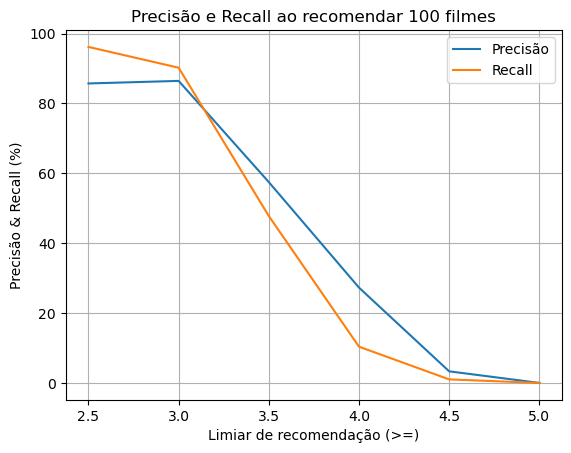

In [76]:
sns.lineplot(
    data=df_metrics,
    x='Threshold',
    y='Precision',
    label='Precisão'
)

sns.lineplot(
    data=df_metrics,
    x='Threshold',
    y='Recall',
    label='Recall'
)

plt.grid()
plt.legend()
plt.ylabel('Precisão & Recall (%)')
plt.xlabel('Limiar de recomendação (>=)')
plt.title('Precisão e Recall ao recomendar 100 filmes')
plt.savefig('./images/precision_recall_at_100.png')
plt.show()

Salvando modelo

# Investigando embeddings

In [77]:
unique_movies = np.unique(df_movie_lens.movies)
sample_movies = np.random.choice(unique_movies, size=1000, replace=False)

In [78]:
movies_movies_tensor = torch.from_numpy(sample_movies).to(device)

with torch.no_grad():
    movies_embeddings = model.movies_embedding(movies_movies_tensor)

In [79]:
sample_movies_ids = df_movie_lens.get_original_movie_id(sample_movies)
df_movies = pd.read_csv('./data/movie-lens/raw/movies.csv')
movies_genres = df_movies.loc[df_movies['movieId'].isin(sample_movies_ids), 'title'].values.tolist()

In [80]:
writer.add_embedding(
    mat=movies_embeddings,
    metadata=movies_genres
)
writer.flush()
writer.close()